# Transfer learning model results

---

**Model parameters:**

Image types: `Color`, `Grayscale`, `Segmented`

Images size: `256x256`

Model type: `InceptionV3` 

Train-test splits: `70-30`, `50-50`, `30-70`

**Comments:**

Baseline results for InceptionV3 tranfer learning models are included below. Validation accuracy of 99.5% is achieved on a 30% validation set for a model trained using color images. The majority of misclassifications are within specie errors, with only a handful of cases where the predicted specie is inconsistent with that suggested by the label. As might be expected the models trained using the equivalent grayscale images perform worse, but still manage to achieve validation accuracies above 97%.

The model were all run for 20 epochs with each epoch consisting of 500 training and validation steps. The models were trained using Nvidia Tesla K40 GPUs on Odyssey and took in the order of 7 hours to train in parallel.

In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#%cd gdrive/My Drive/research_practice


## Setup and data import

In [15]:
!pip install tqdm

In [16]:
!pip install tensorflow-gpu

In [2]:
!pip install seaborn

In [3]:
!pip install sklearn

In [ ]:
import os
import re
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix
from tqdm import tqdm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

sns.set_palette('deep')
sns.set_context('notebook', font_scale=1.2)

vc_color = '#B5C9EB'

In [ ]:
TRAIN_DIR = "../data/color/70_30/train/"
VAL_DIR = "../data/color/70_30/validation/"
MODEL_DIR = "../models/"

In [ ]:
IM_WIDTH, IM_HEIGHT = 299, 299 
BATCH_SIZE = 32

In [ ]:
# Get image classes
classes = os.listdir(TRAIN_DIR)
num_classes = len(classes)
print(f"Number of classes: {num_classes}")

In [ ]:
# Get path and label for each image
db=[]
for label, class_name in enumerate(classes):
    
    # Train
    path = TRAIN_DIR + class_name
    for file in os.listdir(path):
        db.append(['{}/{}'.format(class_name, file), label, class_name, 1])

    # Validation
    path = VAL_DIR + class_name
    for file in os.listdir(path):
        db.append(['{}/{}'.format(class_name, file), label, class_name, 0])

db = pd.DataFrame(db, columns=['file', 'label', 'class_name', 'train_ind'])

num_train_samples = db.train_ind.sum()
num_val_samples = len(db) - num_train_samples

print(f"Number of train images: {num_train_samples}")
print(f"Number of validation images: {num_val_samples}")

In [ ]:
# train generator
training_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

training_generator = training_datagen.flow_from_directory(
  TRAIN_DIR,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=BATCH_SIZE,
  shuffle=False)

# Validation generator
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
  VAL_DIR,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=BATCH_SIZE,
  shuffle=False)

## Baseline model performance

In [17]:
# Load model
model = load_model(MODEL_DIR + "inception_color_70_30.hdf5")

In [12]:
# # Evaluate model performance
# loss, acc = model.evaluate_generator(validation_generator)

# print("Validation loss: {0:.4f}".format(loss))
# print("Validation accuracy: {0:.4f}".format(acc))


In [18]:
# Get true labels
y_class = db.loc[db.train_ind == 0, 'label']

In [ ]:
# Get predictions for validation data
pred_prob = model.predict_generator(validation_generator, verbose=0)
pred_class = np.argmax(pred_prob, -1)

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_class, pred_class)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = sns.heatmap(cm, ax=ax, cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.yticks(rotation=0)
plt.show();

In [ ]:
cm_std = cm / np.sum(cm, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = sns.heatmap(cm_std, ax=ax, cmap=plt.cm.Greens)
plt.title('Confusion Matrix (Normalized)')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.yticks(rotation=0)
plt.show();

In [ ]:
cm_err = cm
np.fill_diagonal(cm_err, 0)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
msk = cm_err == 0
ax = sns.heatmap(cm_err, ax=ax, cmap=plt.cm.Greens, annot=False, mask=msk)
plt.title('Confusion Matrix (Misclassifcations)')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("images/confusion_matrix.png")
plt.show();

In [ ]:
# Check misclassified images
correct = pred_class == y_class
print(f"Total number of misclassified images: {np.sum(1-correct)}")

In [44]:
def get_specie_name(s):
    return re.findall(".+?___", s)[0][:-3]

In [45]:
name_mapping = db.groupby(['label', 'class_name'])['file'].count()
name_mapping = name_mapping.reset_index()
name_mapping.drop('file', axis=1, inplace=True)

In [46]:
db_val = db.loc[db.train_ind == 0,:]
db_error = db_val[~correct]
db_error['pred'] = pred_class[~correct]

In [47]:
df = db_error.groupby(['label', 'pred'])['file'].count()
df = df.reset_index()

df = df.merge(name_mapping, left_on='label', right_on='label')
df.rename(columns={'class_name':'label_name'}, inplace=True)

df = df.merge(name_mapping, left_on='pred', right_on='label')
df.rename(columns={'class_name':'pred_name'}, inplace=True)
df.rename(columns={'label_x':'label'}, inplace=True)
df.rename(columns={'file':'count'}, inplace=True)
df.drop('label_y', axis=1, inplace=True)

df['label_specie'] = df.label_name.apply(get_specie_name)
df['pred_specie'] = df.pred_name.apply(get_specie_name)
df['specie_error'] = df.apply(lambda s: 1 * (s.label_specie != s.pred_specie) , axis=1)
df

label  pred  count              label_name                pred_name  \
0        0     1    189    Tomato___late_blight      Blueberry___healthy   
1        0     2     73    Tomato___late_blight    Corn___gray_leaf_spot   
2        0     3    118    Tomato___late_blight       Tomato___leaf_mold   
3        1     3    377     Blueberry___healthy       Tomato___leaf_mold   
4        1     4     88     Blueberry___healthy           Corn___healthy   
..     ...   ...    ...                     ...                      ...   
100     29    33    308   Tomato___early_blight  Cherry___powdery_mildew   
101     30    33     95  Peach___bacterial_spot  Cherry___powdery_mildew   
102     30    34    125  Peach___bacterial_spot          Grape___healthy   
103     30    35    465  Peach___bacterial_spot       Apple___apple_scab   
104     31    35      5   Tomato___spider_mites       Apple___apple_scab   

    label_specie pred_specie  specie_error  
0         Tomato   Blueberry             1  
1         Tomato        Corn             1  
2         Tomato      Tomato             0  
3      Blueberry      Tomato             1  
4      Blueberry        Corn             1  
..           ...         ...           ...  
100       Tomato      Cherry             1  
101        Peach      Cherry             1  
102        Peach       Grape             1  
103        Peach       Apple             1  
104       Tomato       Apple             1  

[105 rows x 8 columns]

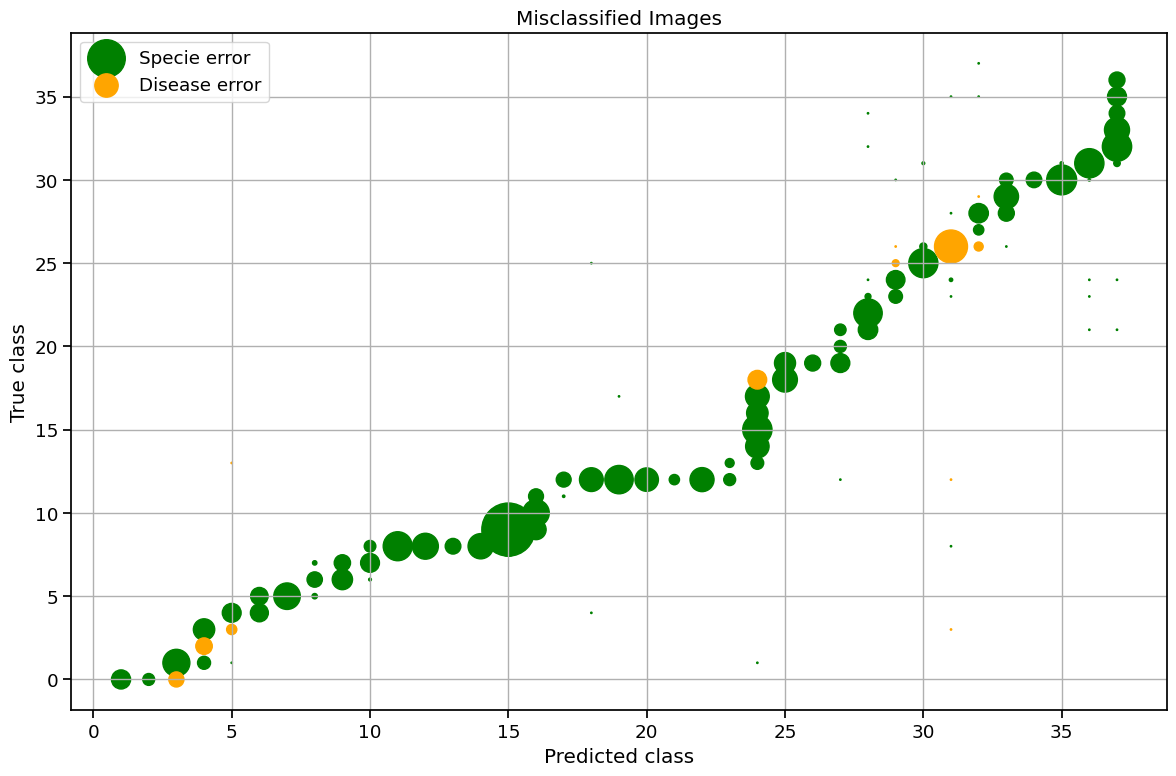

In [49]:
plt.figure(figsize=(12, 8))
plt.scatter(df.pred[df.specie_error==1], df.label[df.specie_error==1], s=df.loc[df.specie_error==1, "count"], color='green');
plt.scatter(df.pred[df.specie_error==0], df.label[df.specie_error==0], s=df.loc[df.specie_error==0, "count"], color='orange');
plt.title('Misclassified Images')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.legend(["Specie error", "Disease error"]);
# Minor ticks
# plt.xticks([4, 5, 7, 11, 15, 16, 18, 20, 23, 24, 25, 26, 28, 38]);
# plt.yticks([4, 5, 7, 11, 15, 16, 18, 20, 23, 24, 25, 26, 28, 38]);
plt.grid();
plt.tight_layout();
plt.savefig("./images/misclassified_images.png")

In [25]:
def format_name(s):
    return re.sub('_+', ' ', s).title()

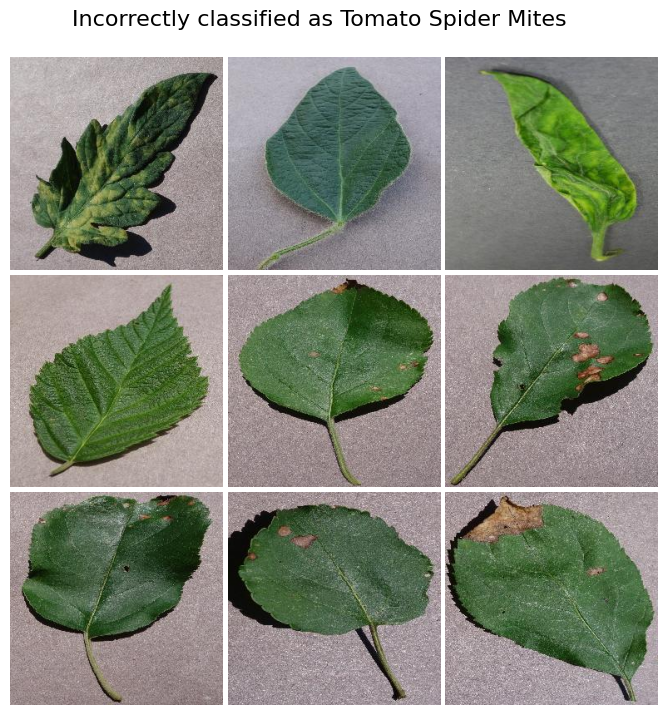

In [26]:
# Examples of incorrectly classified images
pred_idx = 31
df = db_error.loc[db_error.pred == pred_idx,:][:9]
pred_name = format_name(name_mapping.loc[pred_idx, "class_name"])

fig = plt.figure(1, figsize=(12, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)

i = 0

for f, p in zip(df.file.values, df.pred.values):
    ax = grid[i]
    img = image.load_img(VAL_DIR + f, target_size=(256, 256))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.axis('off')
    i += 1

plt.suptitle("Incorrectly classified as " + pred_name, fontsize=16);
plt.subplots_adjust(top=0.92);

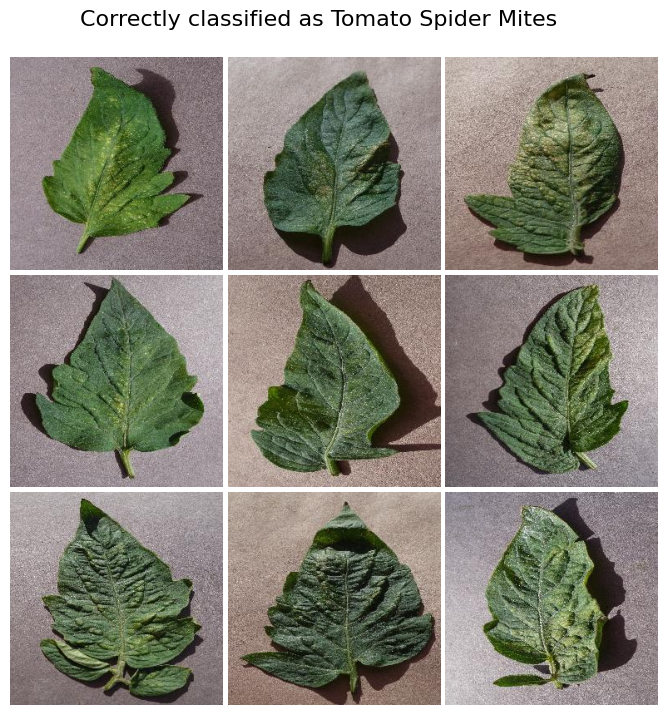

In [27]:
# True examples of incorrectly classified class
idx = 31
df = db.loc[(db.label == idx) & (db.train_ind == 0),:][:9]
pred_name = format_name(name_mapping.loc[idx, "class_name"])

fig = plt.figure(1, figsize=(12, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)

i = 0

for f, p in zip(df.file.values, df.label.values):
    ax = grid[i]
    img = image.load_img(VAL_DIR + f, target_size=(256, 256))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.axis('off')
    i += 1

plt.suptitle("Correctly classified as " + pred_name, fontsize=16);
plt.subplots_adjust(top=0.92);

In [28]:
db_error.head()

file  label  \
1529  Tomato___late_blight/1c6b66db-9891-41cc-972f-a...      0   
1530  Tomato___late_blight/47614fe0-26d7-4259-a78b-5...      0   
1531  Tomato___late_blight/ea8996e6-05f4-4792-9704-e...      0   
1532  Tomato___late_blight/ef80fa2f-c46a-429d-a78a-b...      0   
1533  Tomato___late_blight/e6644ce4-5856-4627-b08d-3...      0   

                class_name  train_ind  pred  
1529  Tomato___late_blight          0     1  
1530  Tomato___late_blight          0     1  
1531  Tomato___late_blight          0     1  
1532  Tomato___late_blight          0     1  
1533  Tomato___late_blight          0     1

In [ ]:
# Examples of incorrectly classified images
pred_idx = 8
label_idx = 10
df = db_error.loc[(db_error.pred == pred_idx) & (db_error.label == label_idx),:][:10]
pred_name = format_name(name_mapping.loc[pred_idx, "class_name"])
label_name = format_name(name_mapping.loc[label_idx, "class_name"])

fig = plt.figure(1, figsize=(10, 4.5))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.05)

i = 0

for f, p in zip(df.file.values, df.pred.values):
    ax = grid[i]
    img = image.load_img(VAL_DIR + f, target_size=(256, 256))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.axis('off')
    i += 1

plt.suptitle(label_name + " incorrectly classified as " + pred_name, fontsize=16);
plt.tight_layout()
plt.savefig("./images/corn_misclassified.png")

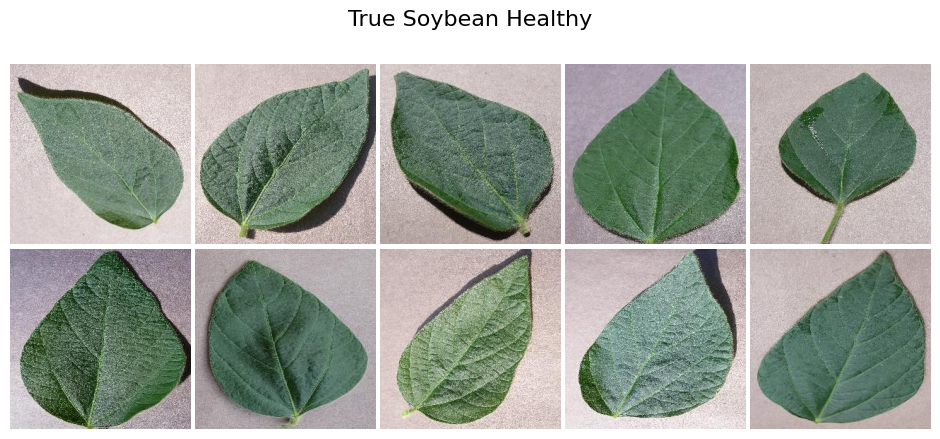

In [30]:
# True examples of incorrectly classified class
idx = 8
df = db.loc[(db.label == idx) & (db.train_ind == 0),:][:10]
pred_name = format_name(name_mapping.loc[idx, "class_name"])

fig = plt.figure(1, figsize=(10, 4.5))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.05)

i = 0

for f, p in zip(df.file.values, df.label.values):
    ax = grid[i]
    img = image.load_img(VAL_DIR + f, target_size=(256, 256))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.axis('off')
    i += 1

plt.suptitle("True " + pred_name, fontsize=16);
plt.tight_layout()
plt.savefig("./images/corn_gray_leaf_spot.png")

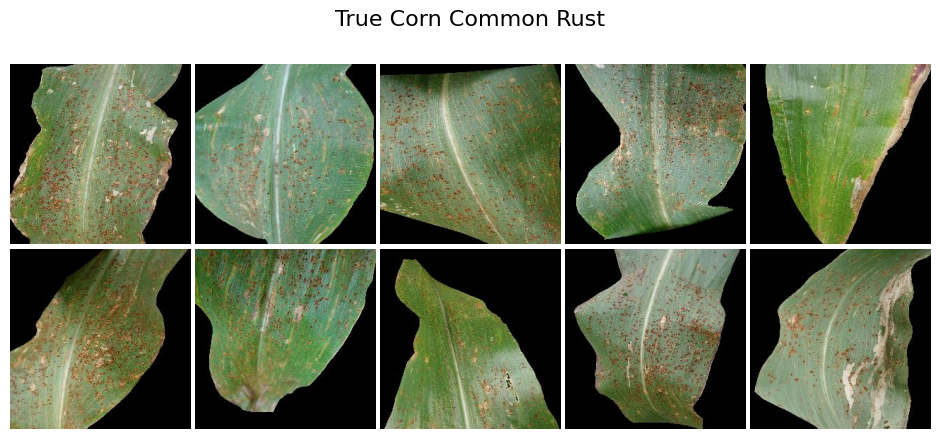

In [31]:
# True examples of incorrectly classified class
idx = 10
df = db.loc[(db.label == idx) & (db.train_ind == 0),:][:10]
pred_name = format_name(name_mapping.loc[idx, "class_name"])

fig = plt.figure(1, figsize=(10, 4.5))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.05)

i = 0

for f, p in zip(df.file.values, df.label.values):
    ax = grid[i]
    img = image.load_img(VAL_DIR + f, target_size=(256, 256))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.axis('off')
    i += 1

plt.suptitle("True " + pred_name, fontsize=16);
plt.tight_layout()
plt.savefig("./images/corn_northern_leaf_blight.png")

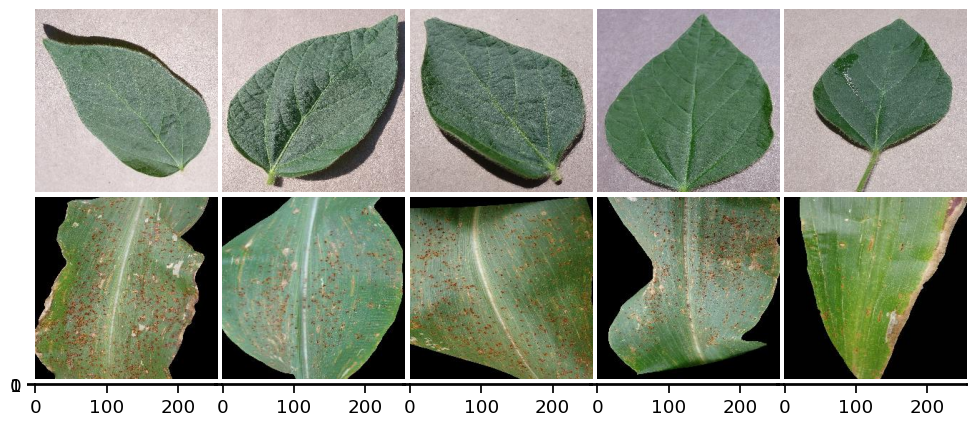

In [32]:
# True examples of incorrectly classified class
pred_idx = 8
label_idx = 10
df = db_error.loc[(db_error.pred == pred_idx) & (db_error.label == label_idx),:][:5]

fig = plt.figure(1, figsize=(10, 4.5))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 5), axes_pad=0.05)

i = 0

for f, p in zip(df.file.values, df.label.values):
    ax = grid[i]
    img = image.load_img(VAL_DIR + f, target_size=(256, 256))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.axis('off')
    i += 1
        
idx = 8
df = db.loc[(db.label == idx) & (db.train_ind == 0),:][:5]
pred_name = format_name(name_mapping.loc[idx, "class_name"])

for f, p in zip(df.file.values, df.label.values):
    ax = grid[i]
    img = image.load_img(VAL_DIR + f, target_size=(256, 256))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.axis('off')
    i += 1
    
idx = 10
df = db.loc[(db.label == idx) & (db.train_ind == 0),:][:5]
pred_name = format_name(name_mapping.loc[idx, "class_name"])

for f, p in zip(df.file.values, df.label.values):
    ax = grid[i]
    img = image.load_img(VAL_DIR + f, target_size=(256, 256))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.axis('off')
    i += 1


plt.tight_layout()
plt.savefig("./images/corn_comparison.png")

## Model comparison

### Performance

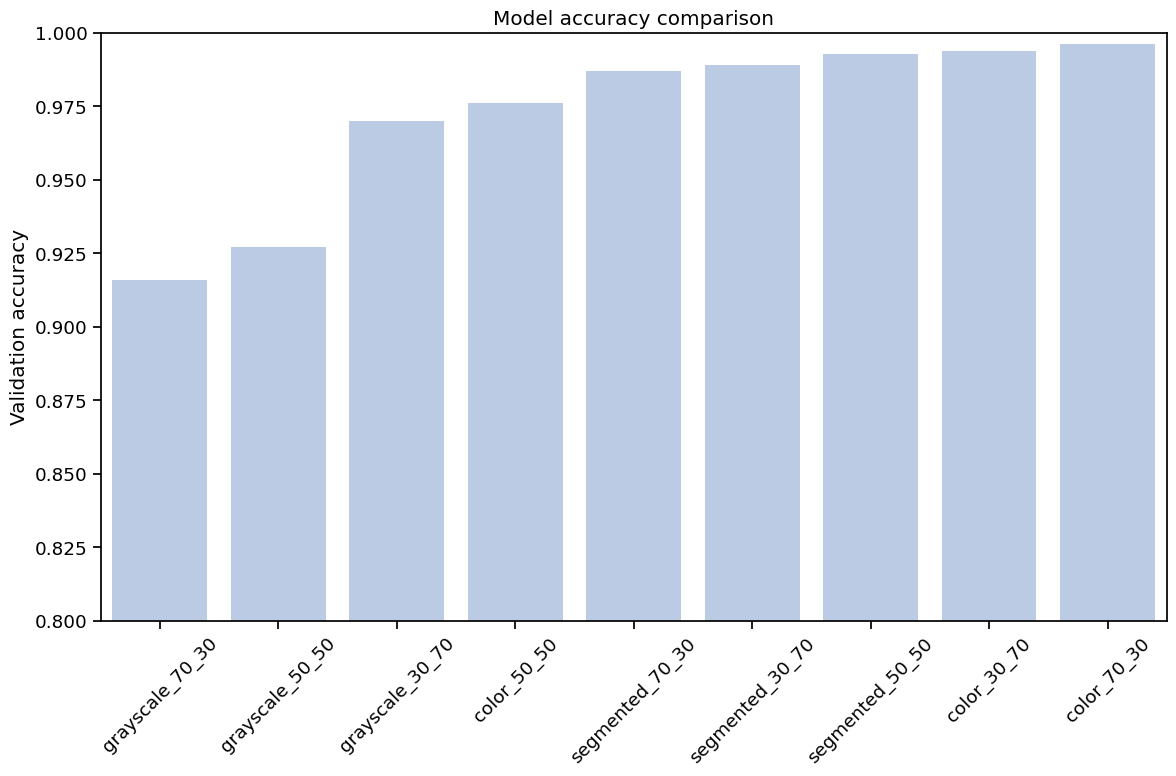

In [51]:
files = [f for f in os.listdir(MODEL_DIR) if ".csv" in f]

i = 0
for f in files:
    df = pd.read_csv(MODEL_DIR + f)
    df['model'] = f.replace(".csv", "")
    df['image_type'] = f.replace(".csv", "")[10:-6]
    df['train_split'] = f.replace(".csv", "")[-5:]
    if i == 0:
        model_results = df
    else:
        model_results = model_results.append(df)   
    i += 1

best_val_acc = {}
for m in set(model_results.model):
    df = model_results.loc[model_results.model == m,]
    val = np.max(df.val_acc)
    best_val_acc[m[10:]] = val

df = pd.DataFrame.from_dict(best_val_acc, orient='index').reset_index()
df.columns = ["model", "val_acc"]
df.sort_values(by="val_acc", inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x="model", y="val_acc", data=df, color=vc_color);
plt.title("Model accuracy comparison")
plt.ylabel("Validation accuracy")
plt.xlabel("")
plt.xticks(rotation = 45);
plt.ylim((0.8, 1));
plt.tight_layout();
plt.savefig("./images/model_comparison.png")

### Training / test splits

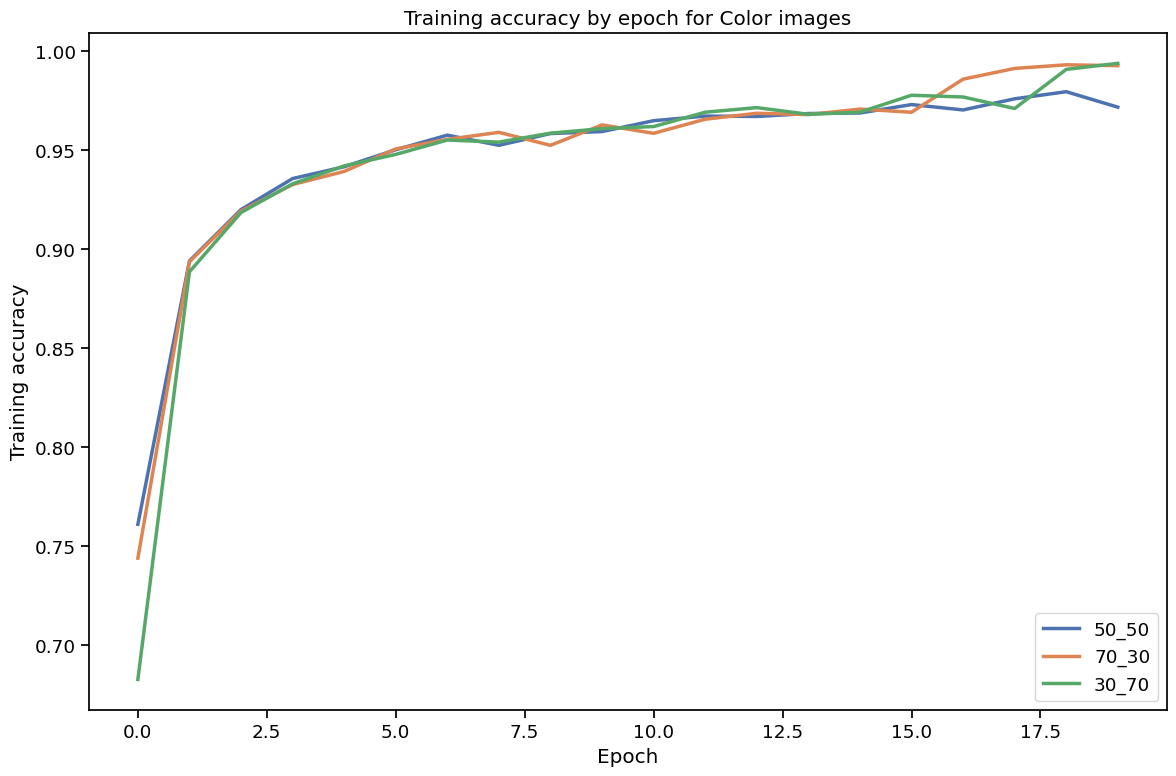

In [34]:
plt.figure(figsize=(12, 8))
df = model_results.loc[model_results.image_type == 'color',:]
for s in set(df.train_split):
    dfp = df.loc[df.train_split == s, :]
    plt.plot(dfp.epoch, dfp.acc, linewidth=2.5);
    plt.legend(set(df.train_split), loc=4);
    plt.xlabel("Epoch");
    plt.ylabel("Training accuracy");
    plt.title("Training accuracy by epoch for Color images");
    plt.tight_layout()
    plt.savefig("./images/training_acc_epoch.png")

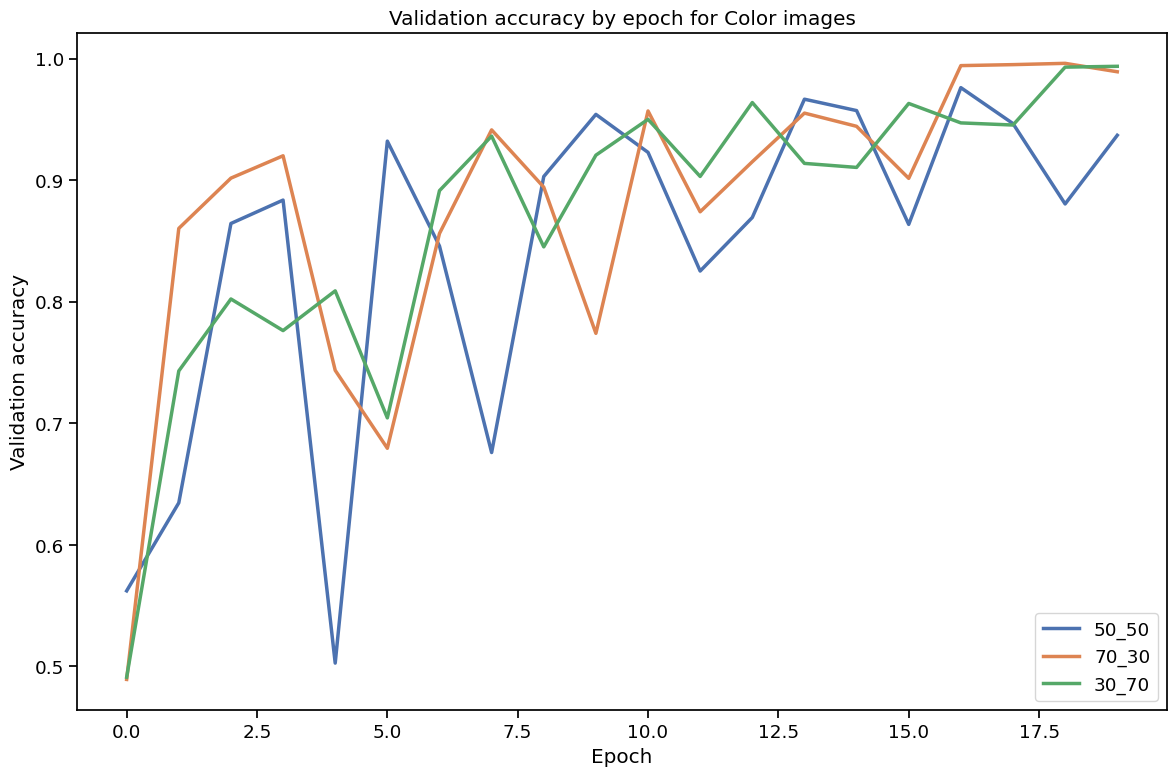

In [35]:
plt.figure(figsize=(12, 8))
df = model_results.loc[model_results.image_type == 'color',:]
for s in set(df.train_split):
    dfp = df.loc[df.train_split == s, :]
    plt.plot(dfp.epoch, dfp.val_acc, linewidth=2.5);
    plt.legend(set(df.train_split), loc=4);
    plt.xlabel("Epoch");
    plt.ylabel("Validation accuracy");
    plt.tight_layout()
    plt.title("Validation accuracy by epoch for Color images");

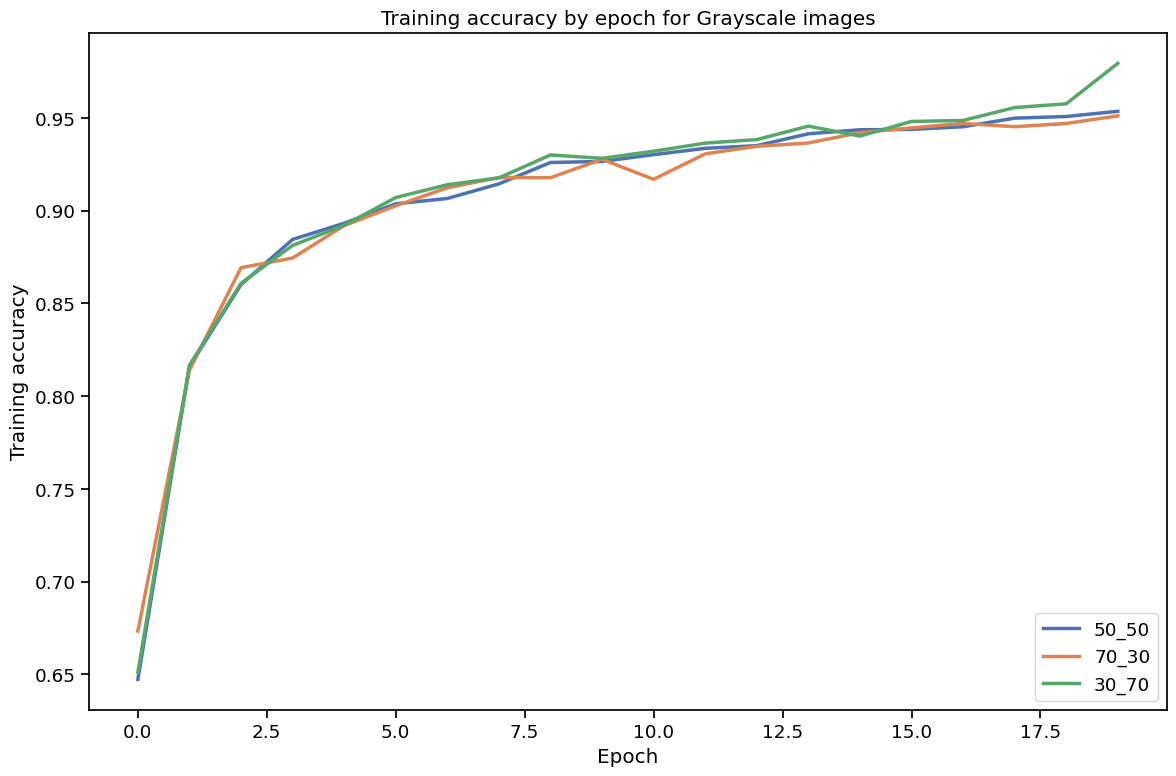

In [36]:
plt.figure(figsize=(12, 8))
df = model_results.loc[model_results.image_type == 'grayscale',:]
for s in set(df.train_split):
    dfp = df.loc[df.train_split == s, :]
    plt.plot(dfp.epoch, dfp.acc, linewidth=2.5);
    plt.legend(set(df.train_split), loc=4);
    plt.xlabel("Epoch");
    plt.ylabel("Training accuracy");
    plt.tight_layout()
    plt.title("Training accuracy by epoch for Grayscale images");

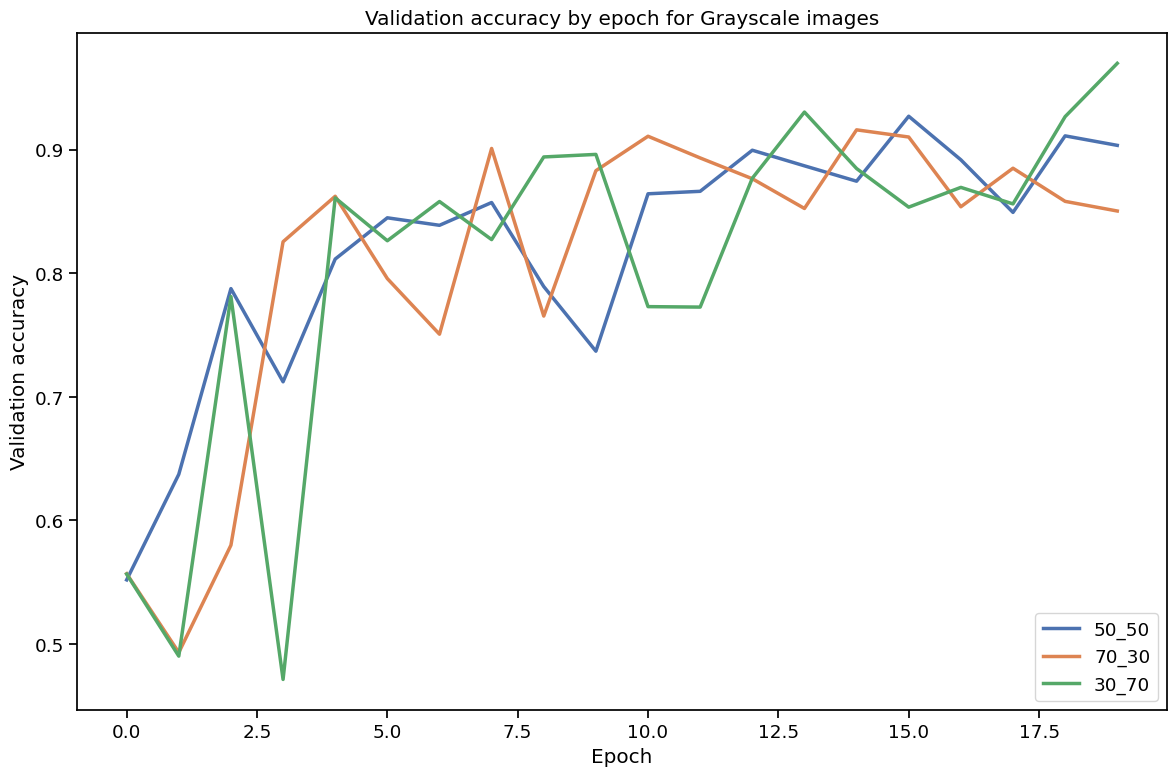

In [37]:
plt.figure(figsize=(12, 8))
df = model_results.loc[model_results.image_type == 'grayscale',:]
for s in set(df.train_split):
    dfp = df.loc[df.train_split == s, :]
    plt.plot(dfp.epoch, dfp.val_acc, linewidth=2.5);
    plt.legend(set(df.train_split), loc=4);
    plt.xlabel("Epoch");
    plt.ylabel("Validation accuracy");
    plt.tight_layout()
    plt.title("Validation accuracy by epoch for Grayscale images")

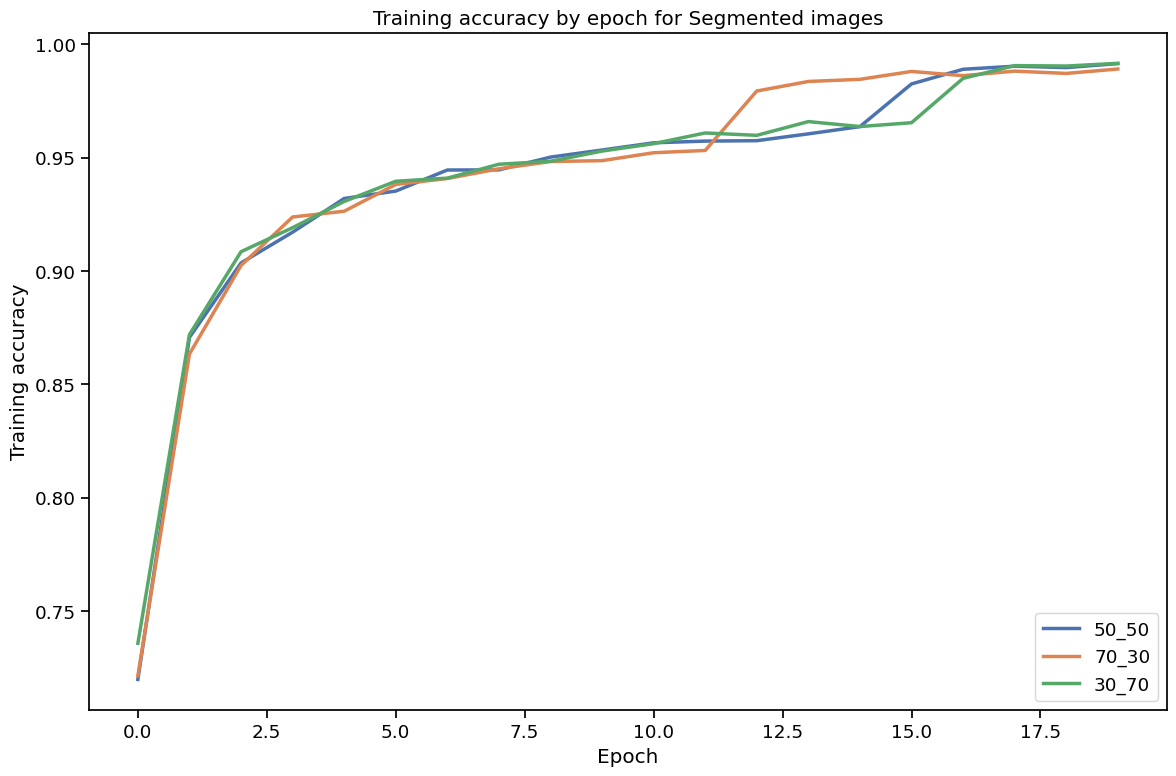

In [38]:
plt.figure(figsize=(12, 8))
df = model_results.loc[model_results.image_type == 'segmented',:]
for s in set(df.train_split):
    dfp = df.loc[df.train_split == s, :]
    plt.plot(dfp.epoch, dfp.acc, linewidth=2.5);
    plt.legend(set(df.train_split), loc=4);
    plt.xlabel("Epoch");
    plt.ylabel("Training accuracy");
    plt.tight_layout()
    plt.title("Training accuracy by epoch for Segmented images");

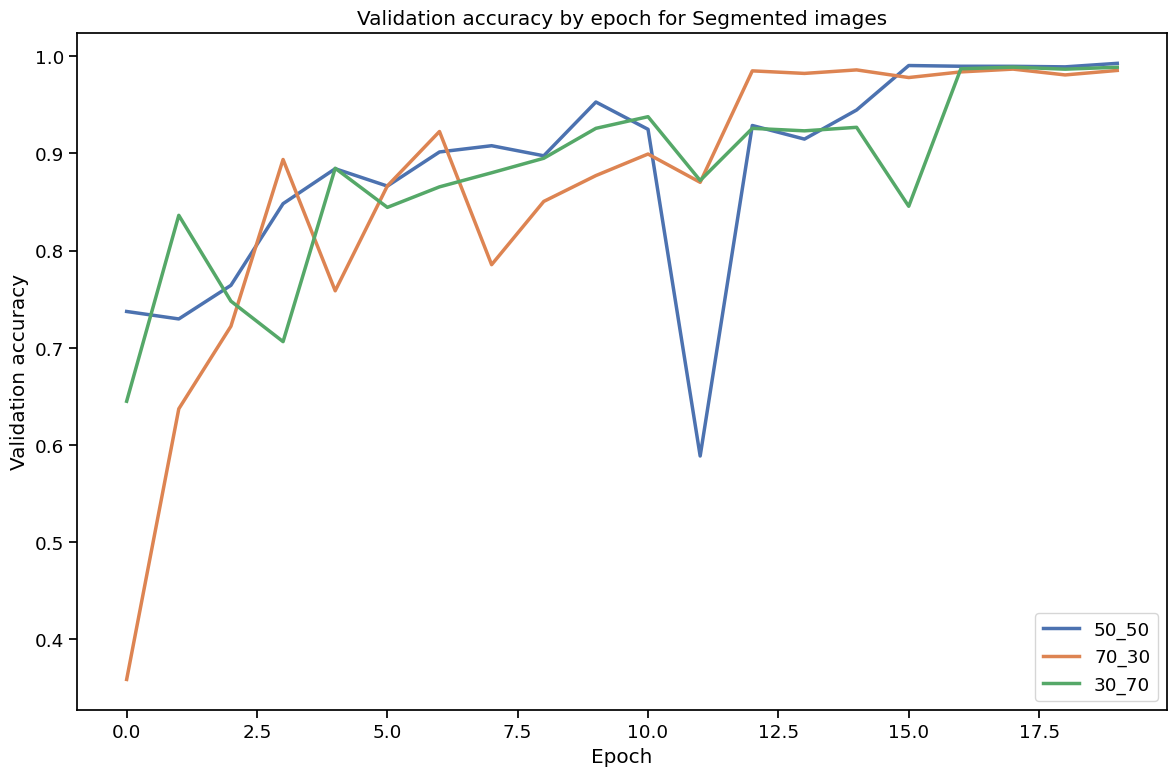

In [39]:
plt.figure(figsize=(12, 8))
df = model_results.loc[model_results.image_type == 'segmented',:]
for s in set(df.train_split):
    dfp = df.loc[df.train_split == s, :]
    plt.plot(dfp.epoch, dfp.val_acc, linewidth=2.5);
    plt.legend(set(df.train_split), loc=4);
    plt.xlabel("Epoch");
    plt.ylabel("Validation accuracy");
    plt.tight_layout()
    plt.title("Validation accuracy by epoch for Segmented images")

### Image types

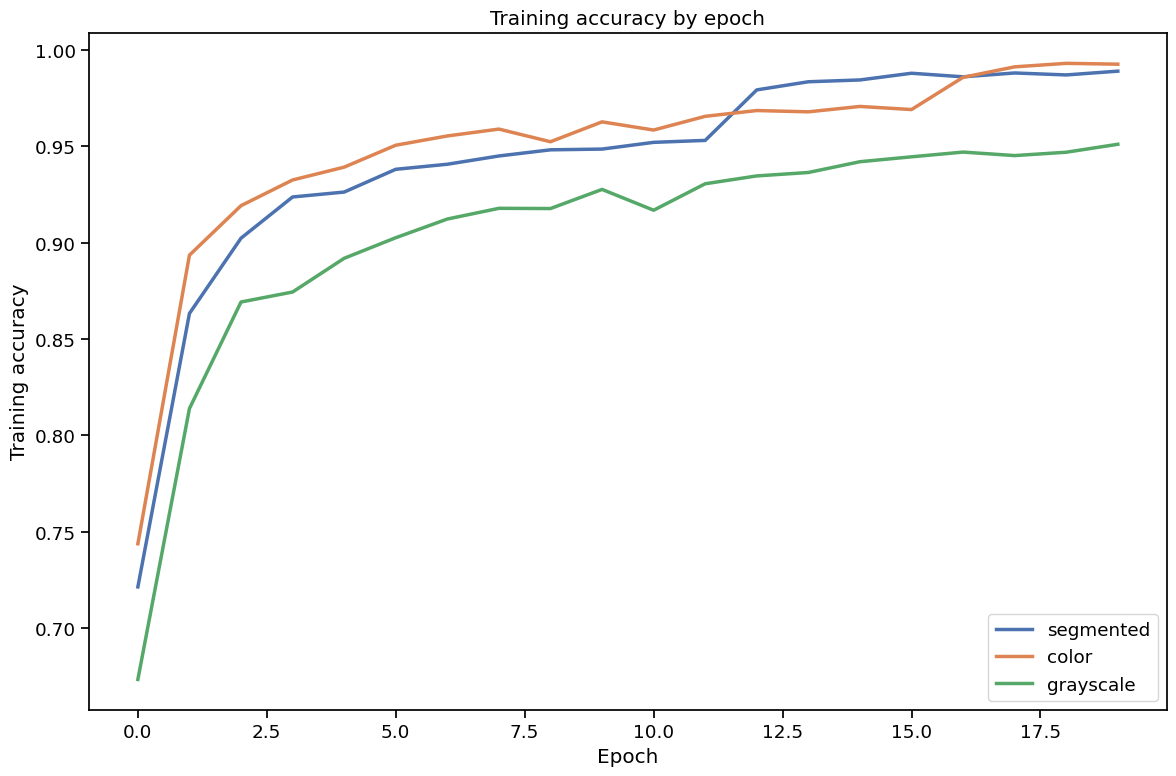

In [40]:
plt.figure(figsize=(12, 8))
df = model_results.loc[model_results.train_split == '70_30',:]
for s in set(df.image_type):
    dfp = df.loc[df.image_type == s, :]
    plt.plot(dfp.epoch, dfp.acc, linewidth=2.5);
    plt.legend(set(df.image_type), loc=4);
    plt.xlabel("Epoch");
    plt.ylabel("Training accuracy");
    plt.tight_layout()
    plt.title("Training accuracy by epoch");

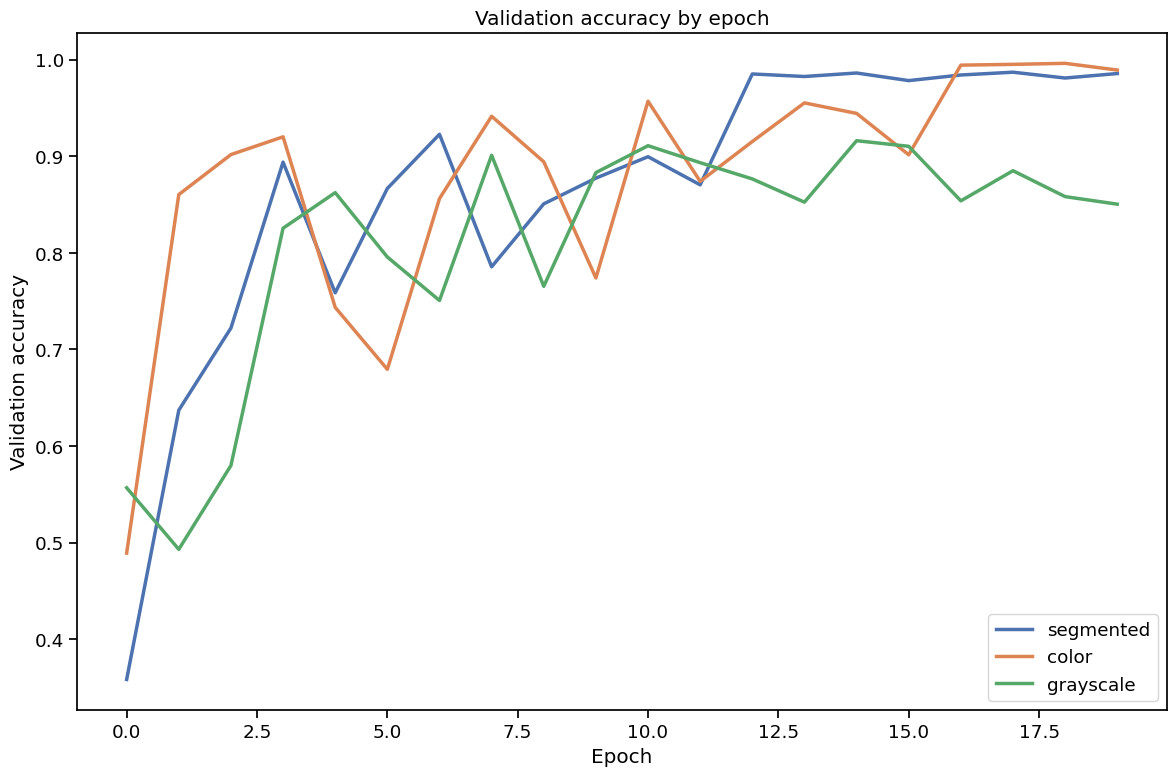

In [41]:
plt.figure(figsize=(12, 8))
df = model_results.loc[model_results.train_split == '70_30',:]
for s in set(df.image_type):
    dfp = df.loc[df.image_type == s, :]
    plt.plot(dfp.epoch, dfp.val_acc, linewidth=2.5);
    plt.legend(set(df.image_type), loc=4);
    plt.xlabel("Epoch");
    plt.ylabel("Validation accuracy");
    plt.tight_layout()
    plt.title("Validation accuracy by epoch");